<a href="https://colab.research.google.com/github/aminsarzaeem/deep/blob/main/hw3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deformable convolution



## A theoretical problems

به صورت جدا در فایل تمرین ارسال شده است.

## B deformable convolution vs traditional convolution

In [90]:
# importing needed libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision.ops
import numpy as np
import random
import time


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In this section we implement first version of deformable convolution(Dia,2017) class. in this module there are 2 convolutional paths.

first, there is a offset path which map input features to 2N channel output (where N is kernel size).corresponding to N 2D offsets.

second, there is a regular convolution path. this is the main convolution which implemented with an offset. the offset is learned from the first convolution path.



In [66]:
# implementing deformable conv module
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        self.padding = padding
        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size * kernel_size,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)
    def forward(self, x):
        h, w = x.shape[2:]
        max_offset = max(h, w)/4.
        offset = self.offset_conv(x).clamp(-max_offset, max_offset)
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          )
        return x

now we implement classifier class that contain 2 convolutional layer, 2 deformable convolutional layer and 2 fully vonnected layer.

In [67]:
class MNISTClassifier(nn.Module):
    def __init__(self,
                 deformable=False):

        super(MNISTClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        conv = nn.Conv2d if deformable==False else DeformableConv2d
        self.conv4 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv5 = conv(32, 32, kernel_size=3, stride=1, padding=1, bias=True)

        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x) # [14, 14]
        x = torch.relu(self.conv2(x))
        x = self.pool(x) # [7, 7]
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        x = self.gap(x)
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

In [70]:
# Training settings

batch_size = 64
lr=0.001
gamma=0.7
epochs=10

# dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST('./data', train=True, download=True,transform=transform)
dataset2 = datasets.MNIST('./data', train=False,transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2,batch_size=batch_size)


In [92]:
#from posixpath import expandvars
use_deformable_conv=True
model = MNISTClassifier(use_deformable_conv).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
loss_function = nn.CrossEntropyLoss()
best_test_acc = 0.

trainloss=[]
test1loss=[]
testloss=[]
times=[]
trainacc=[]
testacc=[]
test1acc=[]

start_time = time.time()
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    correct = 0
    num_data = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        start_time = time.time()

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        end_time= time.time()
        times.append(end_time-start_time)

        train_loss += loss_function(output, target).item()  # sum up batch mean loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_data += len(data)

    trainloss.append(train_loss)
    trainacc.append(100. * correct / num_data)
    acc,lss=test(model, loss_function, device, test_loader)
    #acc1,lss1=test1(model, loss_function, device, test_loader)
    #test1loss.append(lss1)
    testloss.append(lss)
    testacc.append(acc)
    #test1acc.append(acc1)
    best_test_acc = max(best_test_acc, acc)
    #scheduler.step()
    print("best top1 acc(%): ", f"{best_test_acc:.2f}")



Test set: Average loss: 0.0090, Accuracy: 89062/110000 (80.97%)

best top1 acc(%):  80.97

Test set: Average loss: 0.0064, Accuracy: 95111/110000 (86.46%)

best top1 acc(%):  86.46

Test set: Average loss: 0.0055, Accuracy: 97177/110000 (88.34%)

best top1 acc(%):  88.34

Test set: Average loss: 0.0050, Accuracy: 99071/110000 (90.06%)

best top1 acc(%):  90.06

Test set: Average loss: 0.0054, Accuracy: 98503/110000 (89.55%)

best top1 acc(%):  90.06

Test set: Average loss: 0.0044, Accuracy: 99841/110000 (90.76%)

best top1 acc(%):  90.76

Test set: Average loss: 0.0041, Accuracy: 100241/110000 (91.13%)

best top1 acc(%):  91.13

Test set: Average loss: 0.0048, Accuracy: 99074/110000 (90.07%)

best top1 acc(%):  91.13

Test set: Average loss: 0.0055, Accuracy: 97051/110000 (88.23%)

best top1 acc(%):  91.13

Test set: Average loss: 0.0039, Accuracy: 101503/110000 (92.28%)

best top1 acc(%):  92.28


In [99]:
use_deformable_conv=False
model = MNISTClassifier(use_deformable_conv).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
loss_function = nn.CrossEntropyLoss()
best_test_acc = 0.

trainloss2=[]
test1loss=[]
testloss2=[]
times2=[]
trainacc2=[]
testacc2=[]
test1acc=[]

start_time = time.time()
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    correct = 0
    num_data = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        start_time = time.time()

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        end_time= time.time()
        times2.append(end_time-start_time)

        train_loss += loss_function(output, target).item()  # sum up batch mean loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_data += len(data)

    trainloss2.append(train_loss)
    trainacc2.append(100. * correct / num_data)
    acc,lss=test(model, loss_function, device, test_loader)
    #acc1,lss1=test1(model, loss_function, device, test_loader)
    #test1loss.append(lss1)
    testloss2.append(lss)
    testacc2.append(acc)
    #test1acc.append(acc1)
    best_test_acc = max(best_test_acc, acc)
    #scheduler.step()
    print("best top1 acc(%): ", f"{best_test_acc:.2f}")



Test set: Average loss: 0.0136, Accuracy: 81738/110000 (74.31%)

best top1 acc(%):  74.31

Test set: Average loss: 0.0085, Accuracy: 93051/110000 (84.59%)

best top1 acc(%):  84.59

Test set: Average loss: 0.0090, Accuracy: 92000/110000 (83.64%)

best top1 acc(%):  84.59

Test set: Average loss: 0.0089, Accuracy: 92162/110000 (83.78%)

best top1 acc(%):  84.59

Test set: Average loss: 0.0080, Accuracy: 93015/110000 (84.56%)

best top1 acc(%):  84.59

Test set: Average loss: 0.0073, Accuracy: 94324/110000 (85.75%)

best top1 acc(%):  85.75

Test set: Average loss: 0.0065, Accuracy: 95472/110000 (86.79%)

best top1 acc(%):  86.79

Test set: Average loss: 0.0062, Accuracy: 96639/110000 (87.85%)

best top1 acc(%):  87.85

Test set: Average loss: 0.0064, Accuracy: 96941/110000 (88.13%)

best top1 acc(%):  88.13

Test set: Average loss: 0.0060, Accuracy: 97567/110000 (88.70%)

best top1 acc(%):  88.70


In [95]:
def test(model, loss_function, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    num_data = 0
    with torch.no_grad():
        for data, target in test_loader:
            org_data, target = data.to(device), target.to(device)

            for scale in np.arange(0.5, 1.6, 0.1): # [0.5, 0.6, ... ,1.2, 1.3, 1.4, 1.5]
                data = transforms.functional.affine(org_data, scale=scale, angle=0, translate=[0,0],shear=0)
                output = model(data)
                test_loss += loss_function(output, target).item()  # sum up batch mean loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                num_data += len(data)

    test_loss /= num_data

    test_acc = 100. * correct / num_data
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, num_data,
        test_acc))
    return test_acc,test_loss

In [82]:
def test1(model, loss_function, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    num_data = 0
    with torch.no_grad():
        for data, target in test_loader:
            org_data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # sum up batch mean loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            num_data += len(data)

    test_loss /= num_data

    test_acc = 100. * correct / num_data
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, num_data,
        test_acc))
    return test_acc,test_loss

time of deform: 0.004760328996410248
time of without deform: 0.0029535192162243287


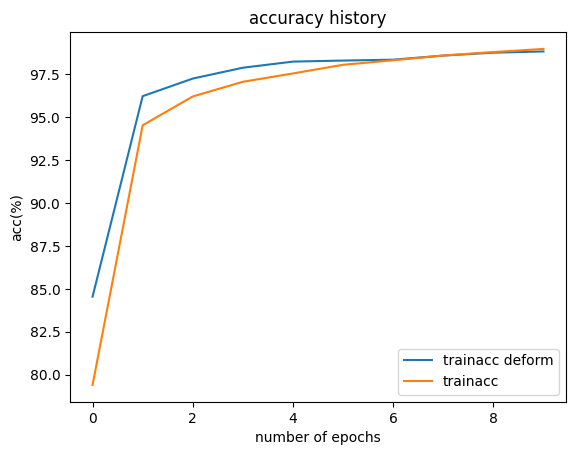

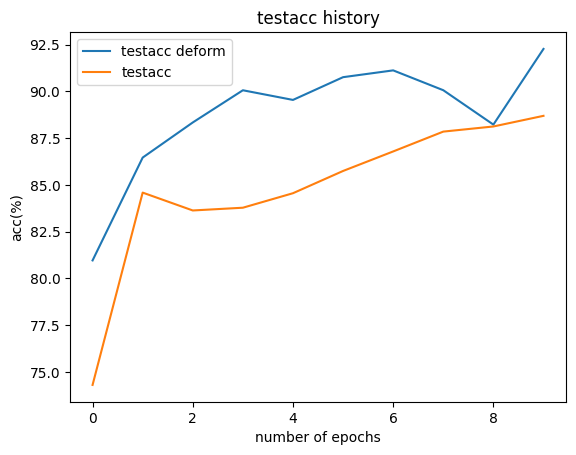

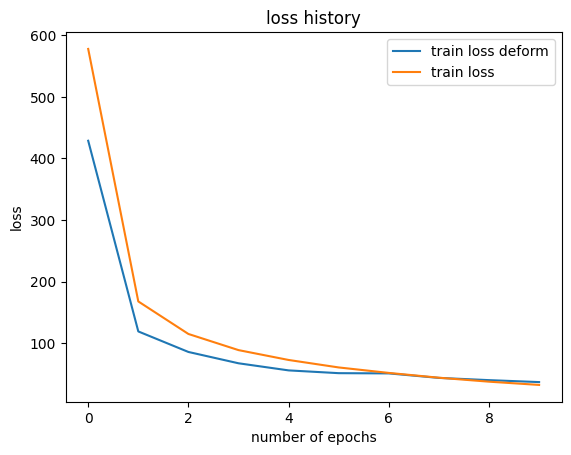

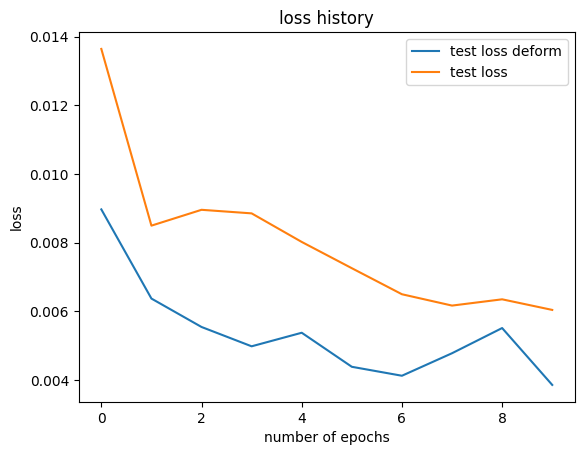

In [100]:
print('time of deform:',np.average(np.array(times)))
print('time of without deform:',np.average(np.array(times2)))
#plot accuracy per epoch
plt.plot(trainacc,label='trainacc deform')
plt.plot(trainacc2,label='trainacc')
plt.title('accuracy history')
plt.xlabel('number of epochs')
plt.ylabel('acc(%)')
plt.legend()
plt.show()
#plot accuracy per epoch
plt.plot(testacc,label='testacc deform')
plt.plot(testacc2,label='testacc')
plt.title('testacc history')
plt.xlabel('number of epochs')
plt.ylabel('acc(%)')
plt.legend()
plt.show()
#plot loss per epoch
plt.plot(trainloss,label='train loss deform')
plt.plot(trainloss2,label='train loss')
plt.title('loss history')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
#plot loss per epoch
plt.plot(testloss,label='test loss deform')
plt.plot(testloss2,label='test loss')
plt.title('loss history')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**conclusion**



*   we observe that average time of training per batch, in deformable architecture is 1.5 times of time of conventional architecture. so it takes considerable more time than convention convolution architecture.
*   in the case of training loss and accuracy, we observe that both ones have the same performance.


*   but the test accuracy and loss of deformable is much better. take care that test data is augmented with scaling and coventional convolution is not able to response to this variations of data.



